# Tutorial 9: Advanced Spiking
In version 1.5.0 of SNS-Toolbox, we have expanded our model of Spiking Neurons and Synapses. In this tutorial, we will showcase the new features of these models. The new spiking models are fully backwards compatible with the original spiking model in SNS-Toolbox, so neurons and synapses which are initialized using only the old parameters will behave as expected.

In [1]:
# Add the library to the path
# If jupyter cannot find SNS-Toolbox
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import packages and modules for designing the network
from sns_toolbox.networks import Network
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.neurons import SpikingNeuron

import numpy as np
import matplotlib.pyplot as plt
from sns_toolbox.plot_utilities import spike_raster_plot

## Spiking Neurons
For the spiking neuron model, we added the following parameters: a threshold leak rate (rate at which the threshold decays to its initial value); a threshold floor (minimum possible value of the threshold); a membrane reset potential (the voltage the neuron is reset to when it spikes), and a threshold increment (constant amount the threshold is incremented at every spike).

In [2]:
type_neuron_spiking_old = SpikingNeuron(threshold_time_constant=5.0,
                                        threshold_initial_value=1.0,
                                        threshold_proportionality_constant=1.0,
                                        bias=20.0)
type_neuron_spiking_new = SpikingNeuron(threshold_time_constant=5.0,
                                        threshold_initial_value=1.0,
                                        threshold_proportionality_constant=1.0,
                                        bias=20.0,
                                        threshold_leak_rate=2.0,    # New in v1.5.0
                                        threshold_floor=0.0,        # New in v1.5.0
                                        reset_potential=-0.1,       # New in v1.5.0
                                        threshold_increment=0.1)    # New in v1.5.0

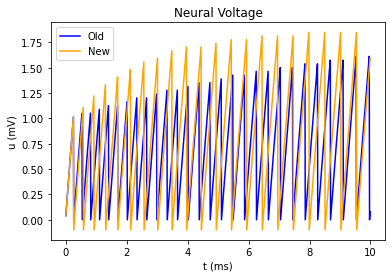

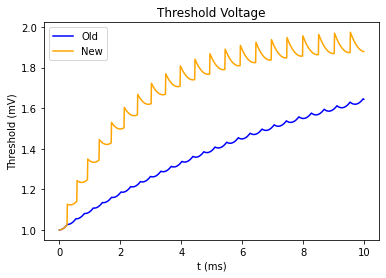

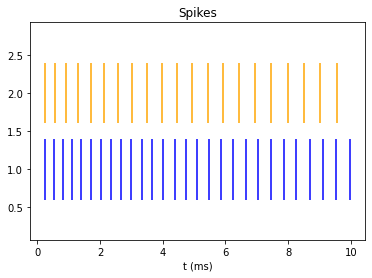

In [3]:
net = Network()
net.add_neuron(type_neuron_spiking_old,'Old')
net.add_neuron(type_neuron_spiking_new, 'New')

net.add_output('Old')
net.add_output('New')
net.add_output('Old',spiking=True)
net.add_output('New', spiking=True)

dt = 0.01
t_max = 10

t = np.arange(0, t_max, dt)
data = np.zeros([len(t), net.get_num_outputs_actual()])
thresholds = np.zeros([len(t), 2])
# Compile to numpy
model = net.compile(backend='numpy', dt=dt, debug=False)

# Run for all steps
for i in range(len(t)):
    data[i,:] = model()
    thresholds[i,:] = model.theta
data = data.transpose()
thresholds = thresholds.transpose()

"""Plotting the results"""
plt.figure()
plt.plot(t,data[:][0], color='blue', label='Old')
plt.plot(t,data[:][1], color='orange', label='New')
plt.title('Neural Voltage')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('u (mV)')

plt.figure()
plt.plot(t,thresholds[:][0], color='blue', label='Old')
plt.plot(t,thresholds[:][1], color='orange', label='New')
plt.title('Threshold Voltage')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Threshold (mV)')

plt.figure()
plt.title('Spikes')
spike_raster_plot(t, data[:][2:4],colors=['blue','orange'])
plt.xlabel('t (ms)')
plt.show()

## Spiking Synapses
For spiking synapses, we added a conductance increment factor. Previously all spiking synapses reset to a maximum value whenever the presynaptic neuron, now they can increment by a specified interval while being constrained by an upper bound.

In [4]:
net2 = Network()
net2.add_neuron(type_neuron_spiking_new,'Pre')
net2.add_neuron(type_neuron_spiking_new, 'PostOld')
net2.add_neuron(type_neuron_spiking_new, 'PostNew')

synapse_old = SpikingSynapse(max_conductance=1.0,
                             reversal_potential=194.0,
                             time_constant=1.0,
                             transmission_delay=0)
synapse_new = SpikingSynapse(max_conductance=1.0,
                             reversal_potential=194.0,
                             time_constant=1.0,
                             transmission_delay=0,
                             conductance_increment=0.2) # New in v1.5.0

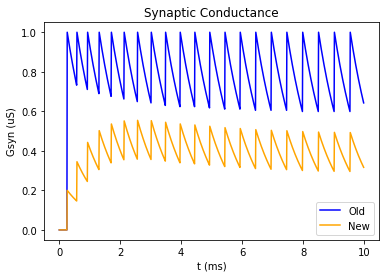

In [5]:
net2.add_connection(synapse_old,'Pre', 'PostOld')
net2.add_connection(synapse_new, 'Pre', 'PostNew')

g_syn = np.zeros([len(t), 2])
# Compile to numpy
model2 = net2.compile(backend='numpy', dt=dt, debug=False)

for i in range(len(t)):
    model2()
    g_syn[i,0] = model2.g_spike[1,0]
    g_syn[i,1] = model2.g_spike[2,0]
g_syn = g_syn.transpose()

plt.figure()
plt.plot(t,g_syn[:][0], color='blue', label='Old')
plt.plot(t,g_syn[:][1], color='orange', label='New')
plt.title('Synaptic Conductance')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Gsyn (uS)')

plt.show()